# Examples of Basic ML Learning Tools

In [1]:
# The goal of this notebook is to look at just the ability of the seed number
# to determine the winner. One caveat here is that the model always should be
# correct when two teams of the same seed go head to head. I could fix it but
# it probably isn't worth the effort. The accuracies seem to be about 70% or 
# maybe 65% considering the imperfect data. I also broke the learning down by
# season just to see if we are potentially getting better at seeding teams. 

In [2]:
import pandas
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier

In [3]:
# UTILITY FUNCTIONS FOR PRE-PROCESSING AND 

# INPUT: Train Dataframe, Test Dataframe, list(column names for training),
# label_col - 'Winner', model - a machine learning model
# RETURNS: the accuracy of the predictions
def predict( train, test, feat_cols, label_col, model ):
    model.fit( train[feat_cols], train[label_col] )
    return model.score( test[feat_cols], test[label_col] )

# INPUT: All the Data, feat_cols - list(columns to train on),
# label_col - 'Winner', model - machine learning model
def test_model( data, feat_cols, label_col, model ):
    accs = []
    for i in range(10):
        train = data.sample( frac=.7 )
        test = data.drop( train.index )
        accs += [predict( train, test, feat_cols, label_col, model )]
    return sum(accs) / len(accs)

# MODELS FROM SKLEARN ################################################
models = {  'LogReg': LogisticRegression(),
            'DecisionTree': DecisionTreeClassifier( max_depth=5 ),
            'NaiveBayes': GaussianNB(),
            'NeuralNet': MLPClassifier(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier( 5 ),
            'SVC': SVC(),
            'BoostClassifier':AdaBoostClassifier() }

# THIS FUNCTION TESTS THE ACCURACY OF THE DATA ON ALL THE MODELS #####
def test_models( data, feat_cols, label_col ):
    for model in models.keys():
        accuracy = test_model( data, feat_cols, label_col, models[model] )
        print( model, ": ", accuracy )

# THIS FUNCTION TESTS AN ENSEMBLE ####################################
# JUST GIVE IT A LIST OF MODEL NAMES AND IT WILL TRAIN THEM ALL AND ##
# VOTE ON THEIR PREDICTIONS. THE FIRST MODEL IS THE TIE BREAKER ######
def test_ensemble( model_names, data, feat_cols, label_col ):
    estimators = []
    estimators.append( (model_names[0], models[model_names[0]]) )
    for name in model_names:
        estimators.append( (name + '1', models[name]) )
        estimators.append( (name + '2', models[name]) )
        
    ensemble = VotingClassifier( estimators=estimators, voting='hard' )
    accuracy = test_model( data, feat_cols, label_col, ensemble )
    print( 'Ensemble: ', accuracy )

# THIS FUNCTION NORMALIZES THE DATA FOR THE COLUMNS GIVEN ############
def normalize( data, col_names ):
    for col in col_names:
        data[col] = data[col] - data[col].min() # SUBTRACT THE MIN ###
        data[col] = data[col] / data[col].max() # DIVIDE BY THE MAX ##
    return data

# THIS IS A HELPER FUNCTION FOR THE SCRAMBLE_WINNER FUNCTION #########
# IT TAKES TWO HALVES OF THE DATA AND RENAMES THE COLUMNS APPROPRIATELY
def rename( half, rest, winner_name, loser_name, generic_name ):
    half = half.rename( index=str, columns={ winner_name: generic_name + '1', loser_name:  generic_name + '2'} )
    rest = rest.rename( index=str, columns={ loser_name:  generic_name + '1', winner_name: generic_name + '2'} )
    return half, rest

# THE DATA IS JUST THE DATA, THE RENAME RULES ARE EACH A SET OF 3 ####
# STRINGS - The columns names for the winner, loser, and the generic #
# name they will get after scrambling ################################
# FOR EXAMPLE: (WRPI, LRPI, RPI) => will rename WRPI and LRPI to #####
# RPI1 and RPI2 ######################################################
def scramble_winner( data, rename_rules ):
    half = data.sample( frac=.5 )
    rest = data.drop( half.index )
    half['Winner'] = 'A'
    rest['Winner'] = 'B'
    
    for rule in rename_rules:
        half, rest = rename( half, rest, rule[0], rule[1], rule[2] )
    
    return pandas.concat( [rest, half] )

All Data
LogReg :  0.715306122449
DecisionTree :  0.672789115646
NaiveBayes :  0.707482993197
NeuralNet :  0.701700680272
RandomForest :  0.675510204082
KNN :  0.660884353741
SVC :  0.699319727891
BoostClassifier :  0.690816326531
Ensemble:  0.694557823129

2004 0.75 NaiveBayes
2005 0.75 RandomForest
2006 0.703125 DecisionTree
2007 0.8125 NaiveBayes
2008 0.765625 LogReg
2009 0.8125 BoostClassifier
2010 0.671875 NaiveBayes
2011 0.671641791045 NeuralNet
2012 0.731343283582 NaiveBayes
2013 0.731343283582 DecisionTree
2014 0.65671641791 LogReg
2015 0.805970149254 SVC
2016 0.716417910448 BoostClassifier
2017 0.761194029851 RandomForest

   LTeamID      POM1      POM2      RPI1      RPI2      SAG1      SAG2  \
1     1436  0.464286  0.006309  0.500000  0.003534  0.547038  0.003257   
2     1211  0.129870  0.006309  0.146853  0.003534  0.132404  0.003257   
3     1323  0.068182  0.006309  0.045455  0.003534  0.055749  0.003257   
4     1272  0.061688  0.097792  0.087413  0.109541  0.080139  0.

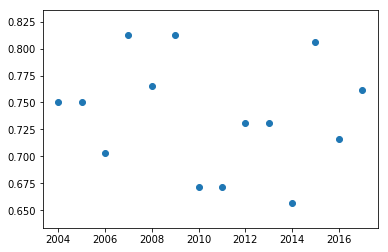

In [4]:
# SOME BASIC TESTING ON SEEDING DATA AND RPI RANKINGS ################
# IMPORT THE DATA ####################################################
data = pandas.read_csv( 'cleaned/TourneySeedsAndRankings.csv' )

# COLUMNS THAT I AM INTERESTED IN LEARNING ON ########################
cols = [ 'SAG', 'Seed', 'RPI', 'POM' ]

# SET UP THE RULES FOR RENAMING SO THAT THE WINNER DATA CAN BE #######
# SCRAMBLED ##########################################################
rules = []
for col in cols:
    rules.append( ('W' + col, 'L' + col, col) )

# SCRAMBLE THE WINNER FROM THE DATA ##################################
data = scramble_winner( data, rules )

# SET UP MY LABEL COLUMNS ############################################
label_cols = []
for name in cols:
    label_cols.append( name + '1' )
    label_cols.append( name + '2' )

# NORMALIZE MY DATA ##################################################
data = normalize(data, label_cols)
   
# PERFORM TESTS ON MY DATA ###########################################
print( 'All Data' )

# TEST ALL THE DATA FOR ALL THE MODELS AND THEN WITH AN ENSEMBLE #####
test_models( data, label_cols, 'Winner' )
test_ensemble( ['LogReg', 'NeuralNet', 'SVC'], data, label_cols, 'Winner' )
print()

# TEST TO SEE THE PREDICTION ACCURACY FOR EACH YEAR ##################
years = {}
for year in range(2004, 2018):
    train = data.loc[ data['Season'] < year ]
    test = data.loc[ data['Season'] == year ]
    results = {}
    for model_name in models.keys():
        acc = predict( train, test, label_cols, 'Winner', models[model_name])
        results[model_name] = acc
    best = max( results.keys(), key=(lambda k: results[k]) )
    print(year, results[best], best)
    years[year] = (best, results[best])
print()

# LOOK AT IF IT IS GETTING EASIER OR HARDER TO PREDICT THE RESULTS ###
import matplotlib.pyplot as plt
%matplotlib inline 
plt.scatter( [year for year in years.keys()], [years[year][1] for year in years.keys()] )
    
# PRINT THE DATA TO MAKE SURE IT ALL LOOKS RIGHT #####################
print(data.head())

In [6]:
# BASIC TESTING ON DIFFERENT TEAM STRENGTH RANKINGS ##############
# I THINK WE CAN ADD PRE-PROCESSING BUT THIS LOOKS DECENT FOR NOW...
data = pandas.read_csv( 'cleaned/TourneyResultsWithRankings.csv' )

# WHAT FEATURES ARE WE INTERESTED IN? ############################
systems = [ 'RPI', 'POM', 'MOR', 'RTH', 'WLK', 'DOL', 'COL', 'SAG' ]

# SET UP THE RULES FOR RENAMING SO THAT THE WINNER DATA CAN BE #######
# SCRAMBLED ##########################################################
rules = []
for col in systems:
    rules.append( ('W' + col, 'L' + col, col) )

# SCRAMBLE THE WINNER FROM THE DATA ##################################
data = scramble_winner( data, rules )

# SET UP MY LABEL COLUMNS ############################################
label_cols = []
for name in systems:
    label_cols.append( name + '1' )
    label_cols.append( name + '2' )
    
# NORMALIZE MY DATA ##################################################
data = normalize(data, label_cols)
    
# TEST THE DATA ######################################################
test_models( data, label_cols, 'Winner' )
test_ensemble( ['LogReg', 'NeuralNet', 'SVC'], data, label_cols, 'Winner' )
data.head()

LogReg :  0.709523809524
DecisionTree :  0.660204081633
NaiveBayes :  0.681292517007
NeuralNet :  0.710884353741
RandomForest :  0.671768707483
KNN :  0.68537414966
SVC :  0.69693877551
BoostClassifier :  0.688775510204
Ensemble:  0.728231292517


,COL1,COL2,DOL1,DOL2,LBIH,LBOB,LCNG,LDOK,LDUN,LMAS,...,WLK2,WMAS,WPGH,WPIG,WSE,WSEL,WTeamID,WWIL,WWOL,Winner
0,0.722603,0.800000,0.853047,0.859532,234.0,239.0,NaN,NaN,247.0,249.0,...,0.825175,265.0,NaN,NaN,210.0,233.0,1421,NaN,220,B
1,0.489726,0.003774,0.555556,0.003344,151.0,158.0,NaN,NaN,110.0,148.0,...,0.003497,3.0,NaN,NaN,2.0,2.0,1112,NaN,2,B
2,0.061644,0.139623,0.071685,0.157191,19.0,22.0,NaN,NaN,19.0,18.0,...,0.115385,40.0,NaN,NaN,44.0,34.0,1113,NaN,39,B
6,0.253425,0.037736,0.322581,0.026756,85.0,76.0,NaN,NaN,45.0,84.0,...,0.013986,10.0,NaN,NaN,12.0,8.0,1181,NaN,9,B
8,0.178082,0.052830,0.193548,0.036789,56.0,63.0,NaN,NaN,42.0,51.0,...,0.031469,11.0,NaN,NaN,16.0,10.0,1228,NaN,14,B


In [8]:
# BASIC TESTING ON SEEDING DATA ##################################
data = pandas.read_csv( 'cleaned/TourneyResultsWithSeeds.csv')

# WHAT FEATURES ARE WE INTERESTED IN? ############################
columns = [ 'Seed' ]

# SET UP THE RULES FOR RENAMING SO THAT THE WINNER DATA CAN BE #######
# SCRAMBLED ##########################################################
rules = []
for col in columns:
    rules.append( ('W' + col, 'L' + col, col) )

# SCRAMBLE THE WINNER FROM THE DATA ##################################
data = scramble_winner( data, rules )

# SET UP MY LABEL COLUMNS ############################################
label_cols = []
for name in columns:
    label_cols.append( name + '1' )
    label_cols.append( name + '2' )
    
# NORMALIZE MY DATA ##################################################
data = normalize(data, label_cols)
    
# TEST THE DATA ######################################################
test_models( data, label_cols, 'Winner' )
test_ensemble( ['LogReg', 'NeuralNet', 'SVC'], data, label_cols, 'Winner' )
data.head()

LogReg :  0.717952755906
DecisionTree :  0.702519685039
NaiveBayes :  0.711496062992
NeuralNet :  0.714330708661
RandomForest :  0.697637795276
KNN :  0.67905511811
SVC :  0.69905511811
BoostClassifier :  0.709763779528
Ensemble:  0.705039370079


,BetterSeedWon,LScore,LTeamID,Season,Seed1,Seed2,SeedDiff,WScore,WTeamID,Winner
4,True,46,1396,1985,0.466667,0.000000,7,63,1207,B
6,True,54,1210,1985,0.066667,0.000000,1,60,1207,B
8,False,55,1425,1985,0.466667,0.533333,-1,58,1229,B
10,False,58,1449,1985,0.266667,0.733333,-7,66,1246,B
11,False,61,1424,1985,0.200000,0.733333,-8,64,1246,B
